In [1]:
import os
import json
import numpy as np
import xarray as xr #查看.nc4 data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import h5py
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [2]:
pip install numpy xarray matplotlib cartopy netCDF4 h5netcdf

Note: you may need to restart the kernel to use updated packages.


## 1. Check the data sample

In [3]:
file_path = "/Users/lijinpeng/Desktop/MDoyster/data/Climate/noaa_nc4_files/ACSPOCW_2007season1_SEASONAL_MULTISAT_SST-NGT_MA_750M.nc4"

In [4]:
# open .nc4
ds = xr.open_dataset(file_path)

# Display the dataset metadata, including variables and dimensions
print("Dataset Info:")
print(ds)

Dataset Info:
<xarray.Dataset> Size: 22MB
Dimensions:      (x: 940, y: 970, time: 1, n_vals: 2, level: 1)
Coordinates:
  * x            (x) float64 8kB -8.624e+06 -8.623e+06 ... -7.658e+06 -7.657e+06
  * y            (y) float64 8kB 5.143e+06 5.142e+06 ... 4.146e+06 4.145e+06
    lat          (y, x) float64 7MB ...
    lon          (y, x) float64 7MB ...
  * time         (time) datetime64[ns] 8B 2007-02-14T14:00:00
  * level        (level) float64 8B 0.0
Dimensions without coordinates: n_vals
Data variables:
    coord_ref    int32 4B ...
    time_bounds  (time, n_vals) datetime64[ns] 16B ...
    sst          (time, level, y, x) float64 7MB ...
Attributes: (12/21)
    cw:polygon_longitude:           [-77.47356397 -75.30150498 -73.129446   -...
    source:                         METOPA_AVHRR
    institution:                    NOAA/NESDIS/STAR
    history:                        [2022-10-07 16:04:06 UTC cwutils-3.7.1.12...
    dcs:createInstitution:          NOAA/NESDIS/STAR
    dcs:cre

In [5]:
print("\nVariables in the file:")
print(ds.variables)


Variables in the file:
Frozen({'coord_ref': <xarray.Variable ()> Size: 4B
[1 values with dtype=int32]
Attributes:
    longitude_of_prime_meridian:     0.0
    longitude_of_projection_origin:  0.0
    standard_parallel:               0.0
    false_easting:                   0.0
    false_northing:                  0.0
    semi_major_axis:                 6378137.0
    inverse_flattening:              298.257223653
    grid_mapping_name:               mercator, 'x': <xarray.IndexVariable 'x' (x: 940)> Size: 8kB
array([-8624317.690714, -8623287.690714, -8622257.690714, ..., -7659207.690714,
       -7658177.690714, -7657147.690714])
Attributes:
    standard_name:  projection_x_coordinate
    units:          m, 'y': <xarray.IndexVariable 'y' (y: 970)> Size: 8kB
array([5143224.209891, 5142194.209891, 5141164.209891, ..., 4147214.209891,
       4146184.209891, 4145154.209891])
Attributes:
    standard_name:  projection_y_coordinate
    units:          m, 'lat': <xarray.Variable (y: 970, x: 9

In [6]:
# View detailed "sst" variable
print(ds["sst"])

<xarray.DataArray 'sst' (time: 1, level: 1, y: 970, x: 940)> Size: 7MB
[911800 values with dtype=float64]
Coordinates:
  * x        (x) float64 8kB -8.624e+06 -8.623e+06 ... -7.658e+06 -7.657e+06
  * y        (y) float64 8kB 5.143e+06 5.142e+06 ... 4.146e+06 4.145e+06
    lat      (y, x) float64 7MB ...
    lon      (y, x) float64 7MB ...
  * time     (time) datetime64[ns] 8B 2007-02-14T14:00:00
  * level    (level) float64 8B 0.0
Attributes:
    long_name:     sea_surface_subskin_temperature
    units:         celsius
    cell_methods:  area: mean
    grid_mapping:  coord_ref


## 2. Calculate seasonal averages

In [7]:
data_folder = "/Users/lijinpeng/Desktop/MDoyster/data/Climate/noaa_nc4_files"

In [8]:
# obtain the data from 2007-2022 and 2023
files = [os.path.join(data_folder, f) for f in os.listdir(data_folder)] #creates a list of file paths from the data_folder
files_2023 = [f for f in files if "2023" in f] # include only those with "2023" in their names or paths
files_2024 = [f for f in files if "2024" in f]
baseline_files = list(set(files) - set(files_2023)- set(files_2024))

print("Baseline files (2007-2022):")
print(baseline_files)

Baseline files (2007-2022):
['/Users/lijinpeng/Desktop/MDoyster/data/Climate/noaa_nc4_files/ACSPOCW_2017season3_SEASONAL_MULTISAT_SST-NGT_MA_750M.nc4', '/Users/lijinpeng/Desktop/MDoyster/data/Climate/noaa_nc4_files/ACSPOCW_2007season2_SEASONAL_MULTISAT_SST-NGT_MA_750M.nc4', '/Users/lijinpeng/Desktop/MDoyster/data/Climate/noaa_nc4_files/ACSPOCW_2014season2_SEASONAL_MULTISAT_SST-NGT_MA_750M.nc4', '/Users/lijinpeng/Desktop/MDoyster/data/Climate/noaa_nc4_files/ACSPOCW_2016season3_SEASONAL_MULTISAT_SST-NGT_MA_750M.nc4', '/Users/lijinpeng/Desktop/MDoyster/data/Climate/noaa_nc4_files/ACSPOCW_2022season1_SEASONAL_MULTISAT_SST-NGT_MA_750M.nc4', '/Users/lijinpeng/Desktop/MDoyster/data/Climate/noaa_nc4_files/ACSPOCW_2013season3_SEASONAL_MULTISAT_SST-NGT_MA_750M.nc4', '/Users/lijinpeng/Desktop/MDoyster/data/Climate/noaa_nc4_files/ACSPOCW_2021season2_SEASONAL_MULTISAT_SST-NGT_MA_750M.nc4', '/Users/lijinpeng/Desktop/MDoyster/data/Climate/noaa_nc4_files/ACSPOCW_2017season1_SEASONAL_MULTISAT_SST-NGT_M

In [9]:
# Define seasonal grouping based on months
seasons = {"Winter": [12, 1, 2], "Spring": [3, 4, 5], "Summer": [6, 7, 8], "Fall": [9, 10, 11]}

In [10]:
# define a processing function
def process_files_with_h5py(file_list):
    seasonal_data = {season: [] for season in seasons.keys()}
    
    for file in file_list:
        try:
            with h5py.File(file, "r") as f:
                # Extract SST data
                sst = f["sst"][:]
                
                # Replace fill values with NaN
                fill_value = f["sst"].attrs.get("missing_value", None)
                if fill_value is not None:
                    sst = np.where(sst == fill_value, np.nan, sst)
                
                # Decode data
                scale_factor = f["sst"].attrs.get("scale_factor", 1.0)
                add_offset = f["sst"].attrs.get("add_offset", 0.0)
                sst = sst * scale_factor + add_offset
                
                # Extract time data
                time = f["time"][:]
                
                # Convert time to datetime
                base_time = datetime(1970, 1, 1)  # Assume base time is Unix time
                converted_time = [base_time + timedelta(seconds=int(t)) for t in time]
                
                # Get the month
                month = pd.Timestamp(converted_time[0]).month
                
                # Check the season and calculate spatial averages
                for season, months in seasons.items():
                    if month in months:
                        mean_value = float(np.nanmean(sst))  # Spatial average
                        seasonal_data[season].append(mean_value)
        except Exception as e:
            print(f"Skipping file {file} due to error: {e}")
            continue
    
    #  Calculate the average for each season
    return {season: np.nanmean(values) if len(values) > 0 else np.nan for season, values in seasonal_data.items()}


In [11]:
#  Process files from 2007-2022
baseline_seasonal_avg = process_files_with_h5py(baseline_files)
print("Baseline seasonal averages (2007-2022):")
print(baseline_seasonal_avg)

# Process files from 2023
seasonal_avg_2023 = process_files_with_h5py(files_2023)
print("\n2023 seasonal averages:")
print(seasonal_avg_2023)



Skipping file /Users/lijinpeng/Desktop/MDoyster/data/Climate/noaa_nc4_files/.DS_Store due to error: Unable to open file (file signature not found)
Baseline seasonal averages (2007-2022):
{'Winter': np.float64(13.283282820548179), 'Spring': np.float64(18.318005329751905), 'Summer': np.float64(25.14712935991527), 'Fall': np.float64(19.408564031290673)}

2023 seasonal averages:
{'Winter': np.float64(14.377189544554234), 'Spring': np.float64(18.13525859665556), 'Summer': np.float64(25.57924873738788), 'Fall': np.float64(19.175713658155043)}


In [12]:
# 2023 values compared to 2007-2022 baseline
anomalies = {season: seasonal_avg_2023[season] - baseline_seasonal_avg[season] 
             for season in baseline_seasonal_avg.keys()}

# Print anomalies
print("\n2023 anomalies (compared to 2007-2022 baseline):")
for season, anomaly in anomalies.items():
    print(f"{season}: {anomaly:.2f} °C")



2023 anomalies (compared to 2007-2022 baseline):
Winter: 1.09 °C
Spring: -0.18 °C
Summer: 0.43 °C
Fall: -0.23 °C



### 测试解码规则
添加解码条件之前print的结果非常大，猜测sst数据不是实际值。

In [13]:
with h5py.File(file_path, "r") as f:
    # 提取 SST 数据
    sst = f["sst"][:]
    
    # 替换填充值为 NaN
    fill_value = f["sst"].attrs.get("missing_value", None)
    if fill_value is not None:
        sst = np.where(sst == fill_value, np.nan, sst)
    
    # 解码数据
    scale_factor = f["sst"].attrs.get("scale_factor", 1.0) #比例因子
    add_offset = f["sst"].attrs.get("add_offset", 0.0) #偏移量
    sst = sst * scale_factor + add_offset
    
    # 打印解码后数据的统计信息(only the output value is an appropriate value, this decode rule works)
    print(f"SST Min: {np.nanmin(sst):.2f}, SST Max: {np.nanmax(sst):.2f}, SST Mean: {np.nanmean(sst):.2f}")



SST Min: -0.02, SST Max: 23.63, SST Mean: 13.18


## 3. Visualize Space distribution

We should calculate the spatial anomaly first!

In [14]:

# Define the data folder
data_folder = "/Users/lijinpeng/Desktop/MDoyster/data/Climate/noaa_nc4_files"

# Get all .h5 or .nc4 files in the folder
files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".nc4")]

# Define seasons
seasons = {
    "Winter": [12, 1, 2],
    "Spring": [3, 4, 5],
    "Summer": [6, 7, 8],
    "Fall": [9, 10, 11]
}

# Helper function to read and process a single file
def process_single_file(file_path):
    with h5py.File(file_path, "r") as f:
        # Extract SST data
        sst = f["sst"][:]

        # Handle missing values
        fill_value = f["sst"].attrs.get("missing_value", None)
        if fill_value is not None:
            sst = np.where(sst == fill_value, np.nan, sst)

        # Apply scale factor and offset
        scale_factor = f["sst"].attrs.get("scale_factor", 1.0)
        add_offset = f["sst"].attrs.get("add_offset", 0.0)
        sst = sst * scale_factor + add_offset

        # Extract time data and convert to datetime
        time = f["time"][:]
        base_time = datetime(1970, 1, 1)  # Assume Unix time
        converted_time = [base_time + timedelta(seconds=int(t)) for t in time]

        # Extract latitude and longitude
        lat = f["lat"][:]
        lon = f["lon"][:]

    return sst, converted_time, lat, lon

# Function to calculate seasonal averages
def calculate_seasonal_means(file_list, seasons):
    seasonal_data = {season: [] for season in seasons.keys()}
    lat, lon = None, None

    for file in file_list:
        try:
            sst, converted_time, lat, lon = process_single_file(file)

            # Determine the season based on the first timestamp
            month = converted_time[0].month
            for season, months in seasons.items():
                if month in months:
                    seasonal_data[season].append(sst)
        except Exception as e:
            print(f"Skipping file {file} due to error: {e}")

    # Calculate the mean SST for each season
    seasonal_means = {
        season: np.nanmean(np.stack(values, axis=0), axis=0) if values else None
        for season, values in seasonal_data.items()
    }

    return seasonal_means, lat, lon

# Separate files into baseline (2007–2022) and 2023
files_2023 = [f for f in files if "2023" in f]
baseline_files = list(set(files) - set(files_2023))

# Calculate baseline seasonal means (2007–2022)
baseline_seasonal_means, lat, lon = calculate_seasonal_means(baseline_files, seasons)

# Calculate 2023 seasonal means
seasonal_means_2023, _, _ = calculate_seasonal_means(files_2023, seasons)

# Calculate spatial anomalies for each season
spatial_anomalies = {
    season: seasonal_means_2023[season] - baseline_seasonal_means[season]
    for season in seasons.keys()
}

# Save anomalies to disk as .npy files (one for each season)
output_folder = "/Users/lijinpeng/Desktop/MDoyster/data/Climate/output_folder"
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Save anomalies for each season
for season, anomaly in spatial_anomalies.items():
    if anomaly is not None:
        np.save(os.path.join(output_folder, f"anomaly_{season}.npy"), anomaly)

print(f"Spatial anomalies saved to {output_folder}.")


/var/folders/sd/bq10trhj0z7_p4t5bg48p4780000gn/T/ipykernel_40675/1857166739.py:61: RuntimeWarning: Mean of empty slice
  season: np.nanmean(np.stack(values, axis=0), axis=0) if values else None


Spatial anomalies saved to /Users/lijinpeng/Desktop/MDoyster/data/Climate/output_folder.


/var/folders/sd/bq10trhj0z7_p4t5bg48p4780000gn/T/ipykernel_40675/3243280128.py:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[1, 0.92, 1, 0.95])


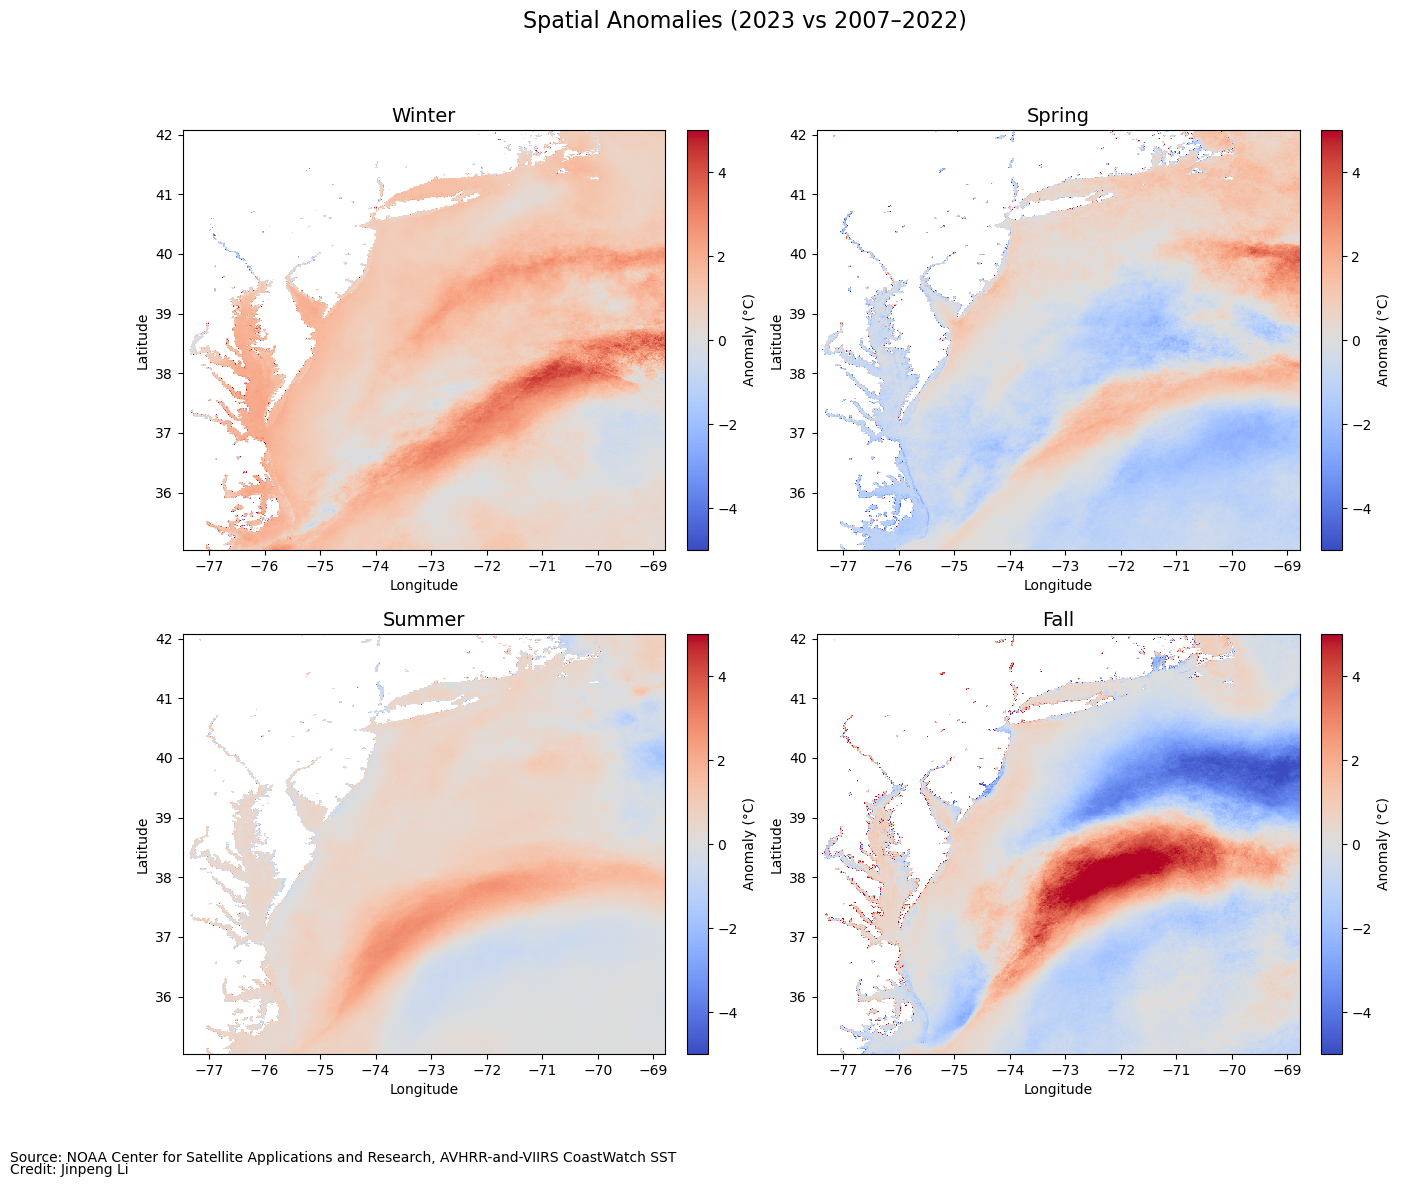

<Figure size 640x480 with 0 Axes>

In [22]:

# Define the folder and seasons
output_folder = "/Users/lijinpeng/Desktop/MDoyster/data/Climate/output"
data_folder = "/Users/lijinpeng/Desktop/MDoyster/data/Climate/noaa_nc4_files"
seasons = ["Winter", "Spring", "Summer", "Fall"]

# Extract latitude and longitude from one file
sample_file = [f for f in os.listdir(data_folder) if f.endswith(".nc4")][0]
sample_file_path = os.path.join(data_folder, sample_file)

with h5py.File(sample_file_path, "r") as f:
    lat = f["lat"][:]
    lon = f["lon"][:]

# Check dimensions and prepare grid if necessary
if lat.ndim == 1 and lon.ndim == 1:
    lat, lon = np.meshgrid(lat, lon)  # Create 2D grid if lat/lon are 1D

# Define the color bar range
vmin = -5  # Minimum anomaly (adjust based on your data)
vmax = 5   # Maximum anomaly (adjust based on your data)


# Create subplots for seasonal anomalies
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Spatial Anomalies (2023 vs 2007–2022)", fontsize=16)

# Loop through seasons and plot each anomaly
for i, season in enumerate(seasons):
    ax = axes[i // 2, i % 2]  # Arrange in a 2x2 grid
    anomaly_file = os.path.join(output_folder, f"anomaly_{season}.npy")

    try:
        # Load anomaly data for the season
        anomaly_data = np.load(anomaly_file).squeeze()  # Remove extra dimensions if present

        # Plot the data
        im = ax.pcolormesh(lon, lat, anomaly_data, cmap="coolwarm", shading="nearest", vmin=vmin, vmax=vmax)
        ax.set_title(f"{season}", fontsize=14)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

        # Add a color bar
        cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
        cbar.set_label("Anomaly (°C)")
    except Exception as e:
        ax.set_title(f"{season} (No Data)")
        print(f"Could not load data for {season}: {e}")

# Adjust layout to prevent overlap
plt.tight_layout(rect=[1, 0.92, 1, 0.95])

# Add source and credit to the figure
fig.text(0.01, 0.02, "Source: NOAA Center for Satellite Applications and Research, AVHRR-and-VIIRS CoastWatch SST", 
         ha="left", fontsize=10)
fig.text(0.01, 0.01, "Credit: Jinpeng Li", ha="left", fontsize=10)

# Show the plot
plt.show()

# 保存图片
output_image_path = "/Users/lijinpeng/Desktop/MDoyster/data/Climate/output/spatial_anomalies_2023.png"
plt.savefig(output_image_path, dpi=300, bbox_inches='tight')


## Export

In [16]:

# 定义路径
output_folder = "/Users/lijinpeng/Desktop/MDoyster/data/Climate/output_folder"
geojson_output_folder = "/Users/lijinpeng/Desktop/MDoyster/data/Climate/geojson_output"
os.makedirs(geojson_output_folder, exist_ok=True)  # 如果输出文件夹不存在，则创建

# 从样本文件中加载纬度和经度
sample_file = "/Users/lijinpeng/Desktop/MDoyster/data/Climate/noaa_nc4_files/ACSPOCW_2022season1_SEASONAL_MULTISAT_SST-NGT_MA_750M.nc4"
with h5py.File(sample_file, "r") as f:
    lat = f["lat"][:]  # 提取纬度
    lon = f["lon"][:]  # 提取经度

# 确保纬度和经度是 2D 网格
if lat.ndim == 1 and lon.ndim == 1:
    lon, lat = np.meshgrid(lon, lat)  # 创建 2D 网格

# 创建 GeoJSON 文件的函数
def create_geojson(lat, lon, data, season, output_folder):
    # 打印形状以调试
    print(f"lat shape: {lat.shape}, lon shape: {lon.shape}, data shape: {data.shape}")

    # 创建 GeoJSON 结构
    geojson = {
        "type": "FeatureCollection",
        "features": []
    }

    # 遍历每个网格点，提取有效值并生成 GeoJSON
    for i in range(lat.shape[0]):
        for j in range(lat.shape[1]):
            value = data[i, j]
            if not np.isnan(value):  # 忽略 NaN 值
                feature = {
                    "type": "Feature",
                    "geometry": {
                        "type": "Point",
                        "coordinates": [float(lon[i, j]), float(lat[i, j])]
                    },
                    "properties": {
                        "anomaly": float(value),
                        "season": season
                    }
                }
                geojson["features"].append(feature)

    # 输出 GeoJSON 文件
    output_path = os.path.join(output_folder, f"{season}_anomalies.geojson")
    with open(output_path, "w") as f:
        json.dump(geojson, f, indent=4)
    print(f"GeoJSON for {season} saved to {output_path}.")

# 遍历每个季节的异常值文件，加载数据并生成 GeoJSON
seasons = ["Winter", "Spring", "Summer", "Fall"]
for season in seasons:
    anomaly_file = os.path.join(output_folder, f"anomaly_{season}.npy")  # 每个季节的 .npy 文件路径
    try:
        # 加载异常值数据并移除多余维度
        data = np.load(anomaly_file).squeeze()  # 移除形状中的 (1, 1)
        create_geojson(lat, lon, data, season, geojson_output_folder)
    except FileNotFoundError:
        print(f"File not found for season {season}: {anomaly_file}")
    except Exception as e:
        print(f"Error processing season {season}: {e}")


lat shape: (970, 940), lon shape: (970, 940), data shape: (970, 940)
GeoJSON for Winter saved to /Users/lijinpeng/Desktop/MDoyster/data/Climate/geojson_output/Winter_anomalies.geojson.
lat shape: (970, 940), lon shape: (970, 940), data shape: (970, 940)
GeoJSON for Spring saved to /Users/lijinpeng/Desktop/MDoyster/data/Climate/geojson_output/Spring_anomalies.geojson.
lat shape: (970, 940), lon shape: (970, 940), data shape: (970, 940)
GeoJSON for Summer saved to /Users/lijinpeng/Desktop/MDoyster/data/Climate/geojson_output/Summer_anomalies.geojson.
lat shape: (970, 940), lon shape: (970, 940), data shape: (970, 940)
GeoJSON for Fall saved to /Users/lijinpeng/Desktop/MDoyster/data/Climate/geojson_output/Fall_anomalies.geojson.
